# Use different metrics to benchmark signature connectivity metrics

The gold standard is the drug MoA from Corsello et al.: https://www.nature.com/nm/journal/v23/n4/full/nm.4306.html

In [1]:
import os, sys, json
from itertools import combinations
import h5py
from pymongo import MongoClient
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial import distance
np.random.seed(10)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'

import seaborn as sns
sns.set_context('talk', font_scale=1.5)


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from joblib import delayed, Parallel

# Implement connectivity metrics 

Connectivity Metrics between a pair of signatures:

`sig1` and `sig2` are 1-D `np.array` with same orders of genes


In [4]:
def _gesa_enrichment_score(ranks_s):
    '''Calculate enrichment score from a rank ordered boolean array.
    ranks_s: np.array([0., 1., 0., 0.])
        - 1.: hits
        - 0.: misses
    '''
    n_hits = ranks_s.sum()
    n_misses = ranks_s.shape[0] - n_hits
    
    p_hit = np.cumsum(ranks_s) / n_hits
    p_miss = np.cumsum(1 - ranks_s) / n_misses
    p_diff = np.absolute(p_hit - p_miss)
    idx = np.argmax(p_diff)
    es = p_hit[idx] - p_miss[idx]
    return es
    
def gsea_score(sig1, sig2, n_sig=100):
    '''GSEA-based Kolmogorov-Smirnov statsitics.
    n_sig: number of top ranked genes to be treated as significant
    '''
    # number of genes
    n = len(sig1)
    # rank genes in sig1 (0: most down gene, 977: most up genes)
    ranks1 = stats.rankdata(sig1) - 1 
    # identify top up/down genes in sig1
    sig1_down = ranks1 < n_sig
    sig1_up = ranks1 > (n-1-n_sig)
    # argsort sig2
    sig2_srt_idx = sig2.argsort()
    # Compute ES: sig1 as query, sig2 as ref rank
    es_up1 = _gesa_enrichment_score( sig1_up[sig2_srt_idx].astype(float) )
    es_down1 = _gesa_enrichment_score( sig1_down[sig2_srt_idx].astype(float) )
    
    # rank genes in sig2
    ranks2 = stats.rankdata(sig2) - 1
    # identify top up/down genes in sig2
    sig2_down = ranks2 < n_sig
    sig2_up = ranks2 > (n-1-n_sig)
    # argsort sig1
    sig1_srt_idx = sig1.argsort()
    # Compute ES: sig2 as query, sig1 as ref rank
    es_up2 = _gesa_enrichment_score( sig2_up[sig1_srt_idx].astype(float) )
    es_down2 = _gesa_enrichment_score( sig2_down[sig1_srt_idx].astype(float) )
    
#     print es_up1, es_down1
#     print es_up2, es_down2
    
    # es_up is using up gene set to find hits in a list ascending ordered, 
    # therefore, the desirable sign should be negative
    score = (es_down1 - es_up1 + es_down2 - es_up2) / 4. 
    return score

def cosine_sim(sig1, sig2):
    '''Cosine similarity'''
    return 1 - distance.cosine(sig1, sig2)

def correlation(sig1, sig2):
    '''Pearson correlation'''
    return 1 - distance.correlation(sig1, sig2)

def pscore(mat, func, n_jobs=1, **kwargs):
    '''mat is a signature by gene matrix, apply func to all pairwise signatures.
    Similar to pdist
    '''
    n = mat.shape[0]
    n_scores = n * (n-1) / 2
    scores = np.zeros(n_scores)
    c = 0
    if n_jobs == 1:
        for i, j in combinations(range(n), 2):
            scores[c] = func(mat[i], mat[j])
            c += 1
    else:
        scores = Parallel(n_jobs=n_jobs, backend='multiprocessing', verbose=10)(
            delayed(func)(mat[i], mat[j], **kwargs) for i, j in combinations(range(n), 2))
        scores = np.array(scores)
    return scores

# Read gold standard of drug MoAs

In [5]:
drug_moa_df = pd.read_csv('../../Repurposing_Hub_export.txt', sep='\t')
print drug_moa_df.shape
drug_moa_df.head()

(5628, 5)


,Name,MOA,Target,Id,Phase
0,A-317491,purinergic receptor antagonist,P2RX3,"BRD-K38019854-323-01-4, BRD-K38019854-001-01-6",Preclinical
1,A-33903,NaN,NaN,BRD-A40302156-001-01-9,Phase 2
2,A-366,histone lysine methyltransferase inhibitor,"EHMT1, EHMT2","BRD-K06182768-001-02-3, BRD-K06182768-001-01-5...",Preclinical
3,A-674563,AKT inhibitor,"AKT1, PKIA, PRKACA",BRD-K78177893-001-02-4,Preclinical
4,A-7,calmodulin antagonist,NaN,BRD-K03301001-003-02-5,Preclinical


In [6]:
drug_moa_df['pert_ids'] = drug_moa_df['Id']\
    .map(lambda x: ','.join(set(['-'.join(item.split('-')[0:2]) for item in x.split(', ')])))

drug_moa_df['pert_id_count'] = drug_moa_df['pert_ids']\
    .map(lambda x: len(x.split(',')))

drug_moa_df['pert_id_count'].value_counts()

1    5179
2     359
3      75
4      11
5       4
Name: pert_id_count, dtype: int64

In [7]:
drug_moa_df.query('pert_id_count > 1').head()

,Name,MOA,Target,Id,Phase,pert_ids,pert_id_count
7,abacavir,nucleoside reverse transcriptase inhibitor,NaN,"BRD-A95032015-065-01-2, BRD-K17443395-065-01-4",Launched,"BRD-A95032015,BRD-K17443395",2
13,abiraterone-acetate,androgen biosynthesis inhibitor,CYP17A1,"BRD-K24048528-001-01-7, BRD-K16133773-001-01-9",Launched,"BRD-K24048528,BRD-K16133773",2
26,acadesine,AMPK activator,NaN,"BRD-K53448858-001-07-0, BRD-K04797704-001-01-9",Phase 3,"BRD-K53448858,BRD-K04797704",2
30,acarbose,glucosidase inhibitor,"AMY2A, GAA, MGAM, SI","BRD-A16444946-001-09-7, BRD-K01621533-001-01-1...",Launched,"BRD-K01621533,BRD-K44276885,BRD-A16444946",3
34,aceclidine,acetylcholine receptor agonist,"CHRM1, CHRM2, CHRM3, CHRM4, CHRM5","BRD-A32673558-003-03-9, BRD-A32673558-001-02-5...",Launched,"BRD-K68075732,BRD-A80567352,BRD-A32673558",3


In [8]:
for col in drug_moa_df.columns:
    print col, drug_moa_df[col].nunique()

Name 5628
MOA 1262
Target 2149
Id 5628
Phase 8
pert_ids 5620
pert_id_count 5


In [9]:
drug_moa_df.count()

Name             5628
MOA              5086
Target           4020
Id               5628
Phase            5627
pert_ids         5628
pert_id_count    5628
dtype: int64

In [10]:
drug_moa_df.set_index('Name', inplace=True)

In [11]:
# A dict from pert_id to name
d_pert_name = {}
for name, row in drug_moa_df.iterrows():
    for pert_id in row['pert_ids'].split(','):
        d_pert_name[pert_id] = name
print len(d_pert_name)

6172


# Load signature data and metadata from MongoDB

1. **chdirLm**: CD signatures created by Qiaonan
2. **CD_nocenter_LM**: CD signatures of treatment samples vs other treatment samples in the batch as controls
3. **CD_center_LM**: Same with 2., but perform CD after mean centering
4. **avg_center_LM**: Mean center treatment samples in the batch, then use the mean differences as signature

In [12]:
def retrieve_signature_meta_df(coll, query):
    cur = coll.find(query, 
                    {'sig_id':True,
                     'pert_id':True,
                     '_id':False
                    })
    meta_df = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
    print meta_df.shape
    
    meta_df['batch'] = meta_df.index.map(lambda x: x.split(':')[0])
    meta_df['batch_prefix'] = meta_df['batch'].map(lambda x:x.split('_')[0])
    meta_df['cell_id'] = meta_df['batch'].map(lambda x:x.split('_')[1])
    meta_df['time'] = meta_df['batch'].map(lambda x:x.split('_')[2])
    return meta_df

In [13]:
# CD signatures produced by Qiaonan 
client = MongoClient('mongodb://146.203.54.131:27017/')
# coll = client['L1000CDS2']['cpcd-gse70138']
coll = client['L1000CDS2']['cpcd-gse70138-without-insignificant']

meta_df = retrieve_signature_meta_df(coll, {'pert_type': 'trt_cp'})
print meta_df.shape
meta_df.head()

(31331, 1)
(31331, 5)


,pert_id,batch,batch_prefix,cell_id,time
sig_id,,,,,
CPC001_HA1E_24H:BRD-A27143604:10.0,BRD-A27143604,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K84709232:10.0,BRD-K84709232,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K23922020:10.0,BRD-K23922020,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K05151076:10.0,BRD-K05151076,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K88358234:10.0,BRD-K88358234,CPC001_HA1E_24H,CPC001,HA1E,24H


In [86]:
# coll = client['L1000CDS2']['cpcd-gse70138']
# coll.distinct('pert_type')

[u'trt_poscon', u'trt_cp']

In [14]:
coll_fwd = client['L1000FWD']['sigs']

In [15]:
# meta_df_fwd = retrieve_signature_meta_df(coll_fwd, {})
meta_df_fwd = retrieve_signature_meta_df(coll_fwd, {'SCS_centered_by_batch': {'$lt': 0.05}})
print meta_df_fwd.shape
meta_df_fwd.head()

(48098, 1)
(48098, 5)


,pert_id,batch,batch_prefix,cell_id,time
sig_id,,,,,
LJP001_HS578T_24H:BRD-K52911425-001-04-9:2,BRD-K52911425,LJP001_HS578T_24H,LJP001,HS578T,24H
LJP001_HS578T_24H:BRD-K69932463-001-05-6:10,BRD-K69932463,LJP001_HS578T_24H,LJP001,HS578T,24H
LJP001_HS578T_24H:BRD-K85606544-001-04-2:10,BRD-K85606544,LJP001_HS578T_24H,LJP001,HS578T,24H
LJP001_HS578T_24H:BRD-K72636697-001-01-5:10,BRD-K72636697,LJP001_HS578T_24H,LJP001,HS578T,24H
LJP001_HS578T_24H:BRD-K13390322-001-02-2:0.4,BRD-K13390322,LJP001_HS578T_24H,LJP001,HS578T,24H


In [16]:
print meta_df['batch'].nunique(), meta_df_fwd['batch'].nunique()

370 649


In [17]:
print meta_df['batch_prefix'].nunique(), meta_df_fwd['batch_prefix'].nunique()
shared_batch_prefix = set(meta_df['batch_prefix'].unique()) & set(meta_df_fwd['batch_prefix'].unique())
print len(shared_batch_prefix)


28 123
23


In [18]:
print meta_df['pert_id'].nunique(), meta_df_fwd['pert_id'].nunique()
shared_pert_ids = set(meta_df['pert_id'].unique()) & set(meta_df_fwd['pert_id'].unique())
print len(shared_pert_ids)

3919 4944
3635


In [19]:
# Subset the two meta_df to keep only shared pert_id and batch_prefix
meta_df = meta_df.loc[meta_df['batch_prefix'].isin(shared_batch_prefix) & meta_df['pert_id'].isin(shared_pert_ids)]
print meta_df.shape

meta_df_fwd = meta_df_fwd.loc[meta_df_fwd['batch_prefix'].isin(shared_batch_prefix) & meta_df_fwd['pert_id'].isin(shared_pert_ids)]
print meta_df_fwd.shape

(21599, 5)
(33782, 5)


In [20]:
print meta_df['pert_id'].nunique(), meta_df_fwd['pert_id'].nunique()
print len(set(meta_df['pert_id'].unique()) & set(meta_df_fwd['pert_id'].unique()))

3584 3586
3583


In [21]:
def retrieve_sig_mat(sig_ids, coll, key):
    '''Retrieve signatures matrix from MongoDB'''
    # Retrieve signature matrix
    sig_mat = np.zeros((len(sig_ids), 978))
    for i, sig_id in enumerate(sig_ids): 
        doc = coll.find_one({'sig_id': sig_id}, {'_id':False, key:True})
        sig_mat[i] = doc[key]
    return sig_mat

# Benchmark using MoA regardless of batch effects

## 1. All pairs of signatures regardless of any experimental conditions

In [22]:
print len(d_pert_name), meta_df['pert_id'].nunique()
pert_ids_with_MoAs = set(d_pert_name) & set(meta_df['pert_id'].unique())
print len(pert_ids_with_MoAs)

6172 3584
1270


In [23]:
meta_df = meta_df.loc[meta_df['pert_id'].isin(pert_ids_with_MoAs)]
print meta_df.shape

meta_df_fwd = meta_df_fwd.loc[meta_df_fwd['pert_id'].isin(pert_ids_with_MoAs)]
print meta_df_fwd.shape

(8949, 5)
(14399, 5)


In [24]:
meta_df = meta_df.sort_index()
meta_df_fwd = meta_df_fwd.sort_index()

In [25]:
# sample 10000 sig_ids for this benchmark
random_idx = np.random.choice(range(meta_df.shape[0]), 1000, replace=False)
meta_df_sample = meta_df.iloc[random_idx]
meta_df_fwd_sample = meta_df_fwd.iloc[random_idx]
print meta_df_sample.shape, meta_df_fwd_sample.shape

(1000, 5) (1000, 5)


In [25]:
def compute_pscores(meta_df, coll, key, n_jobs=1):
    '''Given a meta_df of signatures, compute the pairwise scores and return a df.'''
    sig_ids = meta_df.index.tolist()
    sig_mat = retrieve_sig_mat(sig_ids, coll, key)
    print 'sig_mat retrieved'

    scores_es50 = pscore(sig_mat, gsea_score, n_jobs=n_jobs, n_sig=50)

    scores_cosine = pscore(sig_mat, cosine_sim, n_jobs=n_jobs)
    scores_corr = pscore(sig_mat, correlation, n_jobs=n_jobs)
    
    print 'scores computed'
    n_scores = len(scores_cosine)
    sigs_i = [None] * n_scores
    sigs_j = [None] * n_scores
    c = 0
    for sig_i, sig_j in combinations(sig_ids, 2):
        sigs_i[c] = sig_i
        sigs_j[c] = sig_j
        c += 1

    df = pd.DataFrame({
        'sig_i': sigs_i, 'sig_j': sigs_j, 
        'cosine': scores_cosine,
        'corr': scores_corr,
        'ES50': scores_es50
    })
    return df

In [ ]:
res_scores1 = compute_pscores(meta_df_sample, coll, 'chdirLm', n_jobs=10)
print res_scores1.shape
res_scores1.head()

sig_mat retrieved


[Parallel(n_jobs=10)]: Batch computation too fast (0.0072s.) Setting batch_size=54.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.0869s.) Setting batch_size=248.
[Parallel(n_jobs=10)]: Done 560 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 1348 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 4076 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 7300 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 10524 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 14244 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 17964 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 22180 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 26396 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 31108 tasks      | elapsed:    5.9s
[Parallel(

[Parallel(n_jobs=10)]: Done 2114308 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 2146796 tasks      | elapsed:  6.2min
[Parallel(n_jobs=10)]: Done 2179780 tasks      | elapsed:  6.3min
[Parallel(n_jobs=10)]: Done 2212764 tasks      | elapsed:  6.4min
[Parallel(n_jobs=10)]: Done 2246244 tasks      | elapsed:  6.5min
[Parallel(n_jobs=10)]: Done 2279724 tasks      | elapsed:  6.5min
[Parallel(n_jobs=10)]: Done 2313700 tasks      | elapsed:  6.6min
[Parallel(n_jobs=10)]: Done 2347676 tasks      | elapsed:  6.7min
[Parallel(n_jobs=10)]: Done 2382148 tasks      | elapsed:  6.8min
[Parallel(n_jobs=10)]: Done 2416620 tasks      | elapsed:  6.9min
[Parallel(n_jobs=10)]: Done 2451588 tasks      | elapsed:  7.0min
[Parallel(n_jobs=10)]: Done 2486556 tasks      | elapsed:  7.1min
[Parallel(n_jobs=10)]: Done 2522020 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done 2557484 tasks      | elapsed:  7.3min
[Parallel(n_jobs=10)]: Done 2593444 tasks      | elapsed:  7.4min
[Parallel(

[Parallel(n_jobs=10)]: Done 8112684 tasks      | elapsed: 23.2min
[Parallel(n_jobs=10)]: Done 8176420 tasks      | elapsed: 23.4min
[Parallel(n_jobs=10)]: Done 8240156 tasks      | elapsed: 23.6min
[Parallel(n_jobs=10)]: Done 8304388 tasks      | elapsed: 23.8min
[Parallel(n_jobs=10)]: Done 8368620 tasks      | elapsed: 24.0min
[Parallel(n_jobs=10)]: Done 8433348 tasks      | elapsed: 24.1min
[Parallel(n_jobs=10)]: Done 8498076 tasks      | elapsed: 24.3min
[Parallel(n_jobs=10)]: Done 8563300 tasks      | elapsed: 24.5min
[Parallel(n_jobs=10)]: Done 8628524 tasks      | elapsed: 24.7min
[Parallel(n_jobs=10)]: Done 8694244 tasks      | elapsed: 24.9min
[Parallel(n_jobs=10)]: Done 8759964 tasks      | elapsed: 25.1min
[Parallel(n_jobs=10)]: Done 8826180 tasks      | elapsed: 25.3min
[Parallel(n_jobs=10)]: Done 8892396 tasks      | elapsed: 25.5min
[Parallel(n_jobs=10)]: Done 8959108 tasks      | elapsed: 25.7min
[Parallel(n_jobs=10)]: Done 9025820 tasks      | elapsed: 25.8min
[Parallel(

[Parallel(n_jobs=10)]: Done 993460 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 1015176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 1036892 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 1059320 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 1081748 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 1104888 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 1128028 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 1151880 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 1175732 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 1200296 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 1224860 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 1250136 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 1275412 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 1301400 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 1327388 tasks      | elapsed:  2.8min
[Parallel(n

[Parallel(n_jobs=10)]: Done 6444888 tasks      | elapsed: 13.4min
[Parallel(n_jobs=10)]: Done 6510748 tasks      | elapsed: 13.6min
[Parallel(n_jobs=10)]: Done 6577320 tasks      | elapsed: 13.7min
[Parallel(n_jobs=10)]: Done 6643892 tasks      | elapsed: 13.8min
[Parallel(n_jobs=10)]: Done 6711176 tasks      | elapsed: 14.0min
[Parallel(n_jobs=10)]: Done 6778460 tasks      | elapsed: 14.1min
[Parallel(n_jobs=10)]: Done 6846456 tasks      | elapsed: 14.3min
[Parallel(n_jobs=10)]: Done 6914452 tasks      | elapsed: 14.4min
[Parallel(n_jobs=10)]: Done 6983160 tasks      | elapsed: 14.5min
[Parallel(n_jobs=10)]: Done 7051868 tasks      | elapsed: 14.7min
[Parallel(n_jobs=10)]: Done 7121288 tasks      | elapsed: 14.8min
[Parallel(n_jobs=10)]: Done 7190708 tasks      | elapsed: 15.0min
[Parallel(n_jobs=10)]: Done 7260840 tasks      | elapsed: 15.1min
[Parallel(n_jobs=10)]: Done 7330972 tasks      | elapsed: 15.3min
[Parallel(n_jobs=10)]: Done 7401816 tasks      | elapsed: 15.4min
[Parallel(

[Parallel(n_jobs=10)]: Done 1098184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 1126048 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 1155208 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 1184368 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 1214824 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 1245280 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 1277032 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 1308784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 1341832 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 1374880 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done 1409224 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 1443568 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 1479208 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 1514848 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 1551784 tasks      | elapsed:  3.4min
[Parallel(

[Parallel(n_jobs=10)]: Done 9643360 tasks      | elapsed: 21.2min
[Parallel(n_jobs=10)]: Done 9752872 tasks      | elapsed: 21.5min
[Parallel(n_jobs=10)]: Done 9862384 tasks      | elapsed: 21.7min
[Parallel(n_jobs=10)]: Done 9973192 tasks      | elapsed: 22.0min
[Parallel(n_jobs=10)]: Done 10084000 tasks      | elapsed: 22.2min
[Parallel(n_jobs=10)]: Done 10196104 tasks      | elapsed: 22.5min
[Parallel(n_jobs=10)]: Done 10308208 tasks      | elapsed: 22.7min
[Parallel(n_jobs=10)]: Done 10421608 tasks      | elapsed: 23.0min
[Parallel(n_jobs=10)]: Done 10535008 tasks      | elapsed: 23.2min
[Parallel(n_jobs=10)]: Done 10649704 tasks      | elapsed: 23.5min
[Parallel(n_jobs=10)]: Done 10764400 tasks      | elapsed: 23.7min
[Parallel(n_jobs=10)]: Done 10880392 tasks      | elapsed: 24.0min
[Parallel(n_jobs=10)]: Done 10996384 tasks      | elapsed: 24.2min
[Parallel(n_jobs=10)]: Done 11113672 tasks      | elapsed: 24.5min
[Parallel(n_jobs=10)]: Done 11230960 tasks      | elapsed: 24.7min

scores computed
(12497500, 5)


,ES50,corr,cosine,sig_i,sig_j
0,-0.008588,-0.009433,-0.016583,CPC006_SW948_6H:BRD-K09635314:80.0,CPC005_MCF7_24H:BRD-A92439610:10.0
1,0.165345,0.147137,0.177438,CPC006_SW948_6H:BRD-K09635314:80.0,CPC003_VCAP_6H:BRD-A97739905:10.0
2,-0.165216,-0.106585,-0.121246,CPC006_SW948_6H:BRD-K09635314:80.0,CPC003_VCAP_6H:BRD-K08619838:10.0
3,0.150894,0.071885,0.058146,CPC006_SW948_6H:BRD-K09635314:80.0,CPC006_VCAP_24H:BRD-K15025317:10.0
4,0.082155,0.040680,0.038104,CPC006_SW948_6H:BRD-K09635314:80.0,CPC005_HCC515_6H:BRD-A65145453:10.0


In [ ]:
res_scores2 = compute_pscores(meta_df_fwd_sample, coll_fwd, 'CD_nocenter_LM', n_jobs=10)
print res_scores2.shape

res_scores3 = compute_pscores(meta_df_fwd_sample, coll_fwd, 'CD_center_LM', n_jobs=10)
print res_scores3.shape

res_scores4 = compute_pscores(meta_df_fwd_sample, coll_fwd, 'avg_center_LM', n_jobs=10)
print res_scores4.shape


sig_mat retrieved


[Parallel(n_jobs=10)]: Batch computation too fast (0.0064s.) Setting batch_size=62.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1271s.) Setting batch_size=194.
[Parallel(n_jobs=10)]: Done 640 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1454 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 3588 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 6110 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 8632 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 11542 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 14452 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done 17750 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done 21048 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 24734 tasks      | elapsed:    4.8s
[Parallel(n

In [ ]:
!mkdir -p data

In [ ]:
res_scores1.to_csv('data/signature_connectivities_sample5000_L1000CDS2.cpcd-gse70138.csv')
res_scores2.to_csv('data/signature_connectivities_sample5000_L1000FWD.CD_nocenter_LM.csv')
res_scores3.to_csv('data/signature_connectivities_sample5000_L1000FWD.CD_center_LM.csv')
res_scores4.to_csv('data/signature_connectivities_sample5000_L1000FWD.avg_center_LM.csv')


In [26]:
from sklearn import metrics

In [27]:
def get_ground_truth(res_scores, meta_df, drug_moa_df):
    '''Given the data frame of pairwise scores and the meta_df of sig_id, 
    return a ground truth vector.'''
    # Find drug_names for sig_id
    d_sig_pert = dict(zip(meta_df.index, meta_df['pert_id']))
    drugs_i = [d_pert_name[d_sig_pert[s]] for s in res_scores['sig_i']]
    drugs_j = [d_pert_name[d_sig_pert[s]] for s in res_scores['sig_j']]
    # Find the groud truth of drug pairs (whether they have the same MoAs)
    drug_moa_df = drug_moa_df.dropna(axis=0)
    d_drug_moa = dict(zip(drug_moa_df.index, drug_moa_df['MOA']))
    MoAs_i = [d_drug_moa.get(drug, drug) for drug in drugs_i]
    MoAs_j = [d_drug_moa.get(drug, drug) for drug in drugs_j]
    
    truths = [moa_i == moa_j for moa_i, moa_j in zip(MoAs_i, MoAs_j)]
    truths = np.array(truths).astype(np.int)
    return truths

def get_roc_curve(res_scores, column, truths):
    '''Given res_scores data frame, and specify a column of the connectivity metric,
    return the roc curve.'''
    scores = res_scores[column].values
    scores_normed = (scores - scores.min()) / (scores.max()- scores.min())
    auroc = metrics.roc_auc_score(truths, scores_normed)
    fpr, tpr, thresholds = metrics.roc_curve(truths, scores_normed)
    return auroc, fpr, tpr, thresholds


In [28]:
def group_scores(res_scores, meta_df, same_cell=False):
    '''Group scores to get the follow 4 groups:
    - same drug same batch
    - same drug diff batch
    - diff drug same batch
    - diff drug diff batch
    '''
    d_sig_pert = dict(zip(meta_df.index, meta_df['pert_id']))
    drugs_i = np.array([d_sig_pert[s] for s in res_scores['sig_i']])
    drugs_j = np.array([d_sig_pert[s] for s in res_scores['sig_j']])
    
    # Batch: CPC004
    batches_i = np.array(map(lambda x:x.split('_')[0], res_scores['sig_i']))
    batches_j = np.array(map(lambda x:x.split('_')[0], res_scores['sig_j']))
#     # Batch: CPC004_MCF7_6H
#     batches_i = np.array(map(lambda x:x.split(':')[0], res_scores['sig_i']))
#     batches_j = np.array(map(lambda x:x.split(':')[0], res_scores['sig_j']))
        
    m_same_batch = batches_i == batches_j
    m_diff_batch = batches_i != batches_j
    
    m_same_drug = drugs_i == drugs_j
    m_diff_drug = drugs_i != drugs_j
        
    masks = (m_same_drug & m_same_batch), (m_same_drug & m_diff_batch), \
        (m_diff_drug & m_same_batch), (m_diff_drug & m_diff_batch)
    if same_cell:
        cells_i = np.array(map(lambda x:x.split('_')[1], res_scores['sig_i']))
        cells_j = np.array(map(lambda x:x.split('_')[1], res_scores['sig_j']))
        m_same_cell = cells_i == cells_j
        masks = [m & m_same_cell for m in masks]
    return masks
    

def density_plot_scores(res_scores, meta_df, same_cell=False):
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    m1, m2, m3, m4 = group_scores(res_scores, meta_df, same_cell=same_cell)
    print m1.sum(), m2.sum(), m3.sum(), m4.sum()
    
    for metric, ax in zip(['ES50', 'cosine', 'corr'], [ax1, ax2, ax3]):
        ax = sns.distplot(res_scores.loc[m1][metric], 
                           hist=False, kde=True, ax=ax,
                           label='same drug same batch'
                          )
        ax = sns.distplot(res_scores.loc[m2][metric],
                           hist=False, kde=True, ax=ax,
                           label='same drug diff batch'
                          )
        ax = sns.distplot(res_scores.loc[m3][metric], 
                           hist=False, kde=True, ax=ax,
                           label='diff drug same batch'
                          )
        ax = sns.distplot(res_scores.loc[m4][metric],
                           hist=False, kde=True, ax=ax,
                           label='diff drug diff batch'
                          )        
        
        ax.legend(loc='upper left', prop={'size':10})
        ax.set_xlabel(metric)
        ax.set_ylabel('Density')
        ax.set_xlim([-1, 1])

    fig.tight_layout()
    
    return fig

In [29]:
# res_scores1 = pd.read_csv('data/signature_connectivities_sample5000_L1000CDS2.cpcd-gse70138.csv')
res_scores1 = pd.read_csv('data/signature_connectivities_sample5000_L1000CDS2.cpcd-gse70138.sig_only.csv')
res_scores1.set_index(res_scores1.columns[0], inplace=True)
print res_scores1.shape
res_scores1.head()

(12497500, 5)


,ES50,corr,cosine,sig_i,sig_j
Unnamed: 0,,,,,
0,0.164440,0.152711,0.168388,CPC006_VCAP_24H:BRD-K81418486:11.1,CPC014_A549_24H:BRD-A20697603:10.0
1,0.216369,0.165126,0.163504,CPC006_VCAP_24H:BRD-K81418486:11.1,CPC013_A549_24H:BRD-K66175015:10.0
2,-0.006153,0.029072,0.018320,CPC006_VCAP_24H:BRD-K81418486:11.1,CPC013_VCAP_6H:BRD-K97764662:10.0
3,-0.022187,-0.020206,-0.017625,CPC006_VCAP_24H:BRD-K81418486:11.1,CPC015_MCF7_6H:BRD-A42628519:10.0
4,-0.015022,0.020872,0.020018,CPC006_VCAP_24H:BRD-K81418486:11.1,CPC010_HA1E_6H:BRD-K59369769:10.0


In [30]:
# res_scores2 = pd.read_csv('data/signature_connectivities_sample5000_L1000FWD.CD_nocenter_LM.csv')
# res_scores2.set_index(res_scores2.columns[0], inplace=True)

# res_scores3 = pd.read_csv('data/signature_connectivities_sample5000_L1000FWD.CD_center_LM.csv')
res_scores3 = pd.read_csv('data/signature_connectivities_sample5000_L1000FWD.sig_only.CD_center_LM.csv')
res_scores3.set_index(res_scores3.columns[0], inplace=True)

# res_scores4 = pd.read_csv('data/signature_connectivities_sample5000_L1000FWD.avg_center_LM.csv')
# res_scores4.set_index(res_scores4.columns[0], inplace=True)

In [49]:
# res_scores5 = pd.read_csv('data/signature_connectivities_sample5000_L1000FWD.CD_center_LM_det.csv')
# res_scores5.set_index(res_scores5.columns[0], inplace=True)

# res_scores6 = pd.read_csv('data/signature_connectivities_sample5000_L1000FWD.avg_center_LM_det.csv')
# res_scores6.set_index(res_scores6.columns[0], inplace=True)

In [54]:
# res_scores7 = pd.read_csv('data/signature_connectivities_sample5000_L1000FWD.CDavg_center_LM_det.csv')
# res_scores7.set_index(res_scores7.columns[0], inplace=True)

# res_scores8 = pd.read_csv('data/signature_connectivities_sample5000_L1000FWD.CDavg_nocenter_LM_det.csv')
# res_scores8.set_index(res_scores8.columns[0], inplace=True)

In [30]:
print res_scores1.shape, res_scores2.shape, res_scores3.shape, res_scores4.shape

(12497500, 5) (12497500, 5) (12497500, 5) (12497500, 5)


6438 3539 1242902 11244621


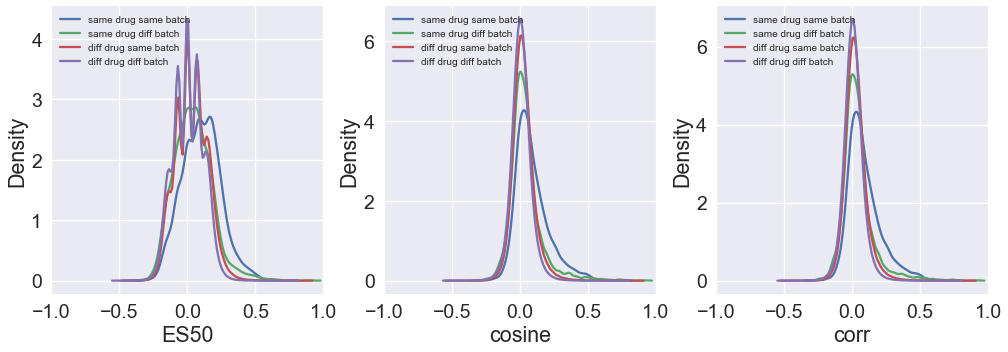

In [74]:
fig = density_plot_scores(res_scores1, meta_df)

171 179 89872 737764


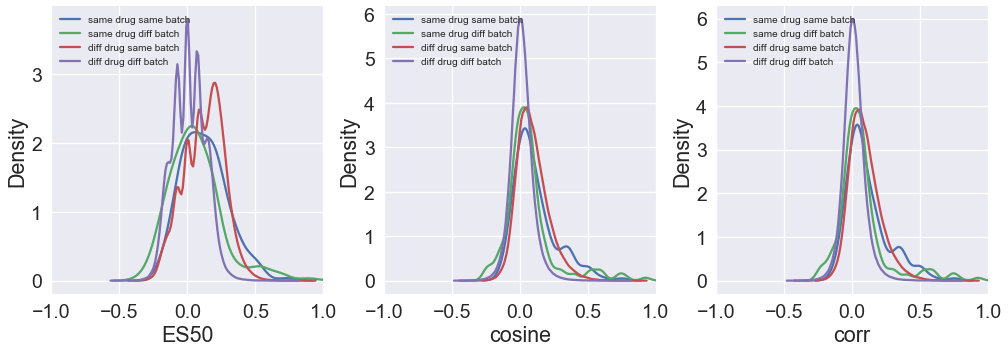

In [75]:
fig = density_plot_scores(res_scores1, meta_df, same_cell=True)

18715 7385 1827877 10643523


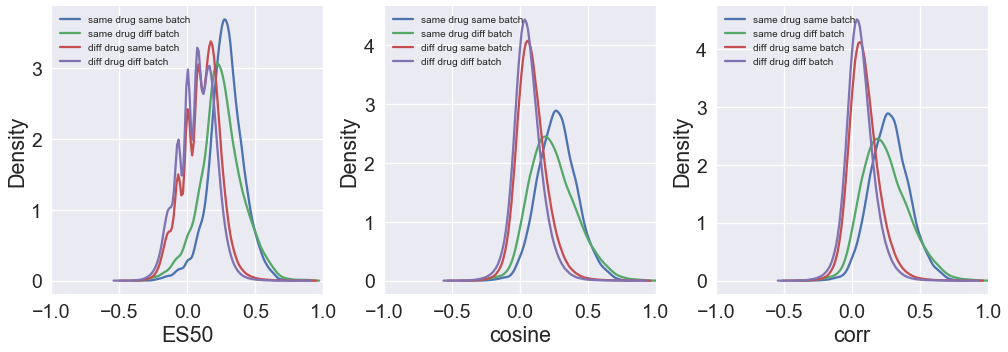

In [31]:
# significant only
fig = density_plot_scores(res_scores1, meta_df)
fig.savefig('figs/Density_connectivity_scores_L1000CDS2.cpcd-gse70138.sig_only.pdf')

29357 9659 3707524 8750960


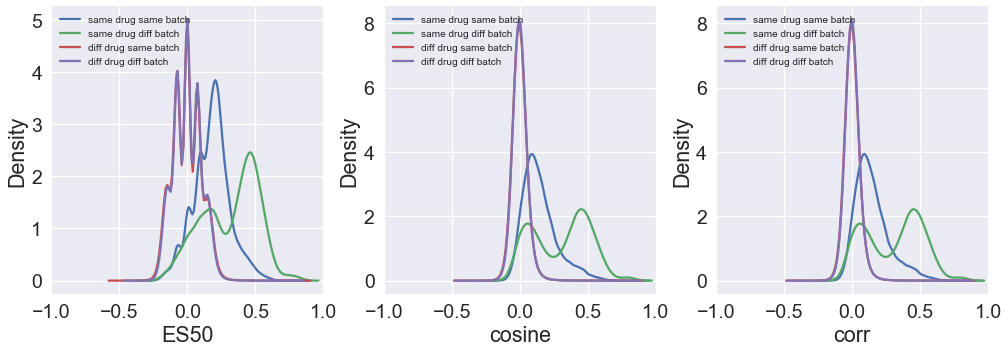

In [32]:
# significant only
fig = density_plot_scores(res_scores3, meta_df_fwd)
fig.savefig('figs/Density_connectivity_scores_L1000FWD.CD_center_LM.sig_only.pdf')

502 396 120559 782697


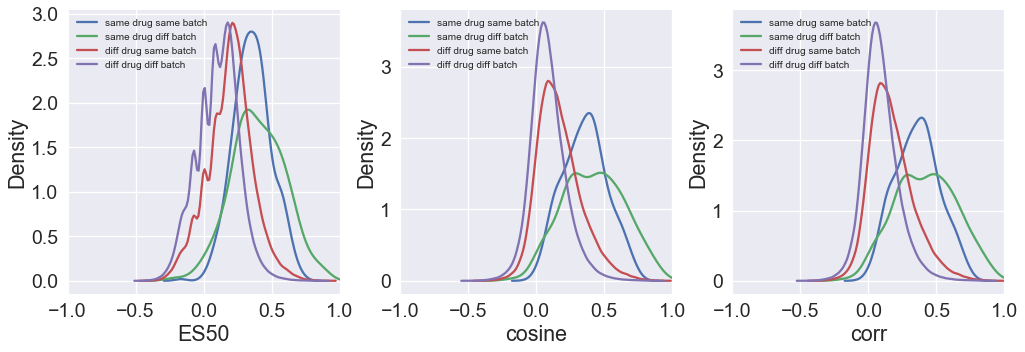

In [31]:
# significant only
fig = density_plot_scores(res_scores1, meta_df, same_cell=True)

637 615 181227 693432


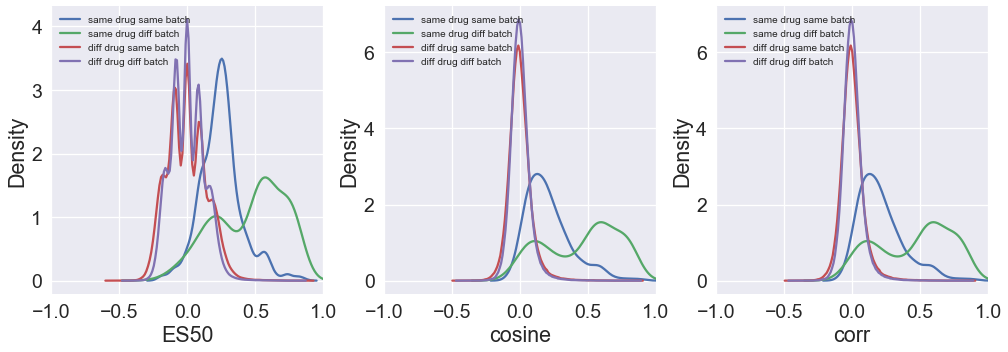

In [32]:
# significant only
fig = density_plot_scores(res_scores3, meta_df_fwd, same_cell=True)

6379 4506 1201302 11285313


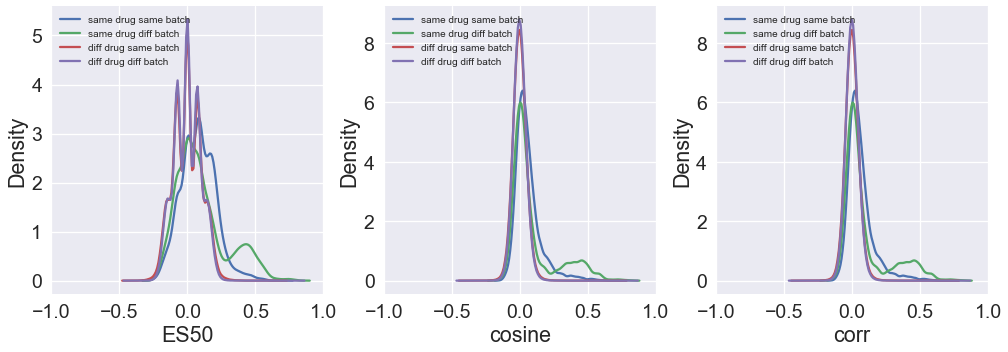

In [39]:
fig = density_plot_scores(res_scores2, meta_df_fwd)

6379 4506 1201302 11285313


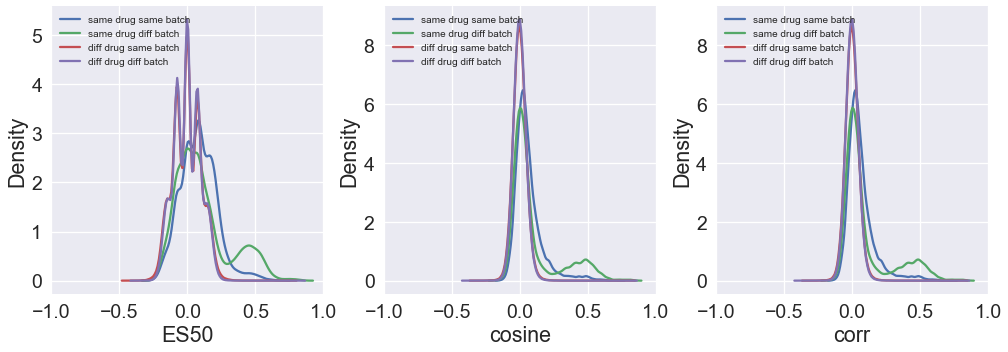

In [40]:
fig = density_plot_scores(res_scores3, meta_df_fwd)

164 247 89177 755947


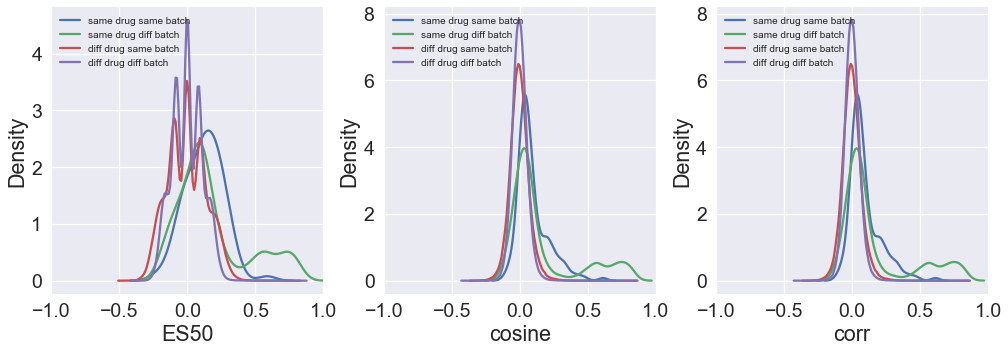

In [76]:
fig = density_plot_scores(res_scores3, meta_df_fwd, same_cell=True)

6379 4506 1201302 11285313


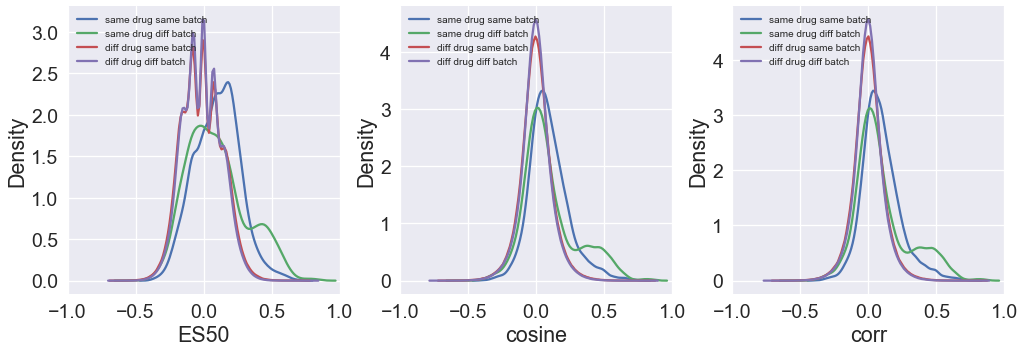

In [41]:
fig = density_plot_scores(res_scores4, meta_df_fwd)

6294 4335 1164810 11322061


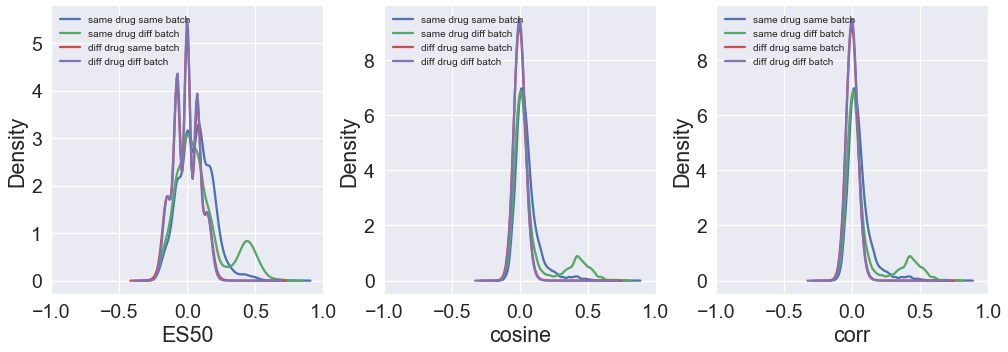

In [50]:
fig = density_plot_scores(res_scores5, meta_df_fwd)

6294 4335 1164810 11322061


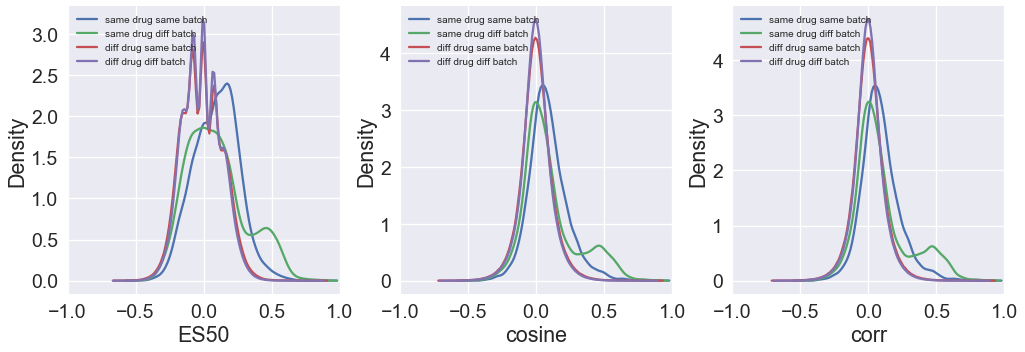

In [51]:
fig = density_plot_scores(res_scores6, meta_df_fwd)

6294 4335 1164810 11322061


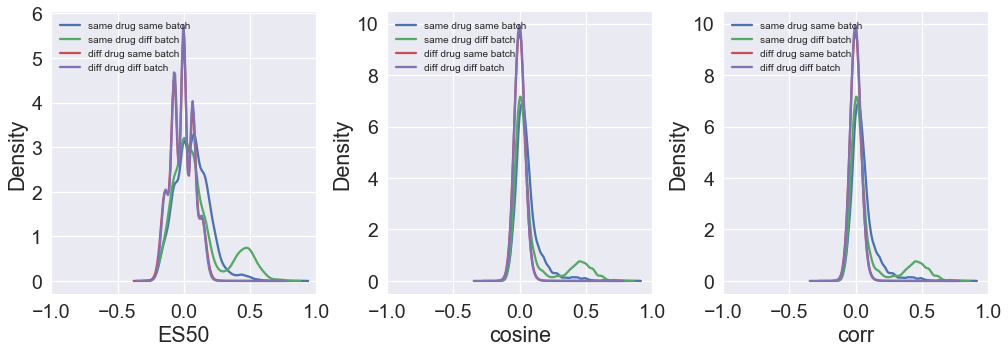

In [55]:
fig = density_plot_scores(res_scores7, meta_df_fwd)

6294 4335 1164810 11322061


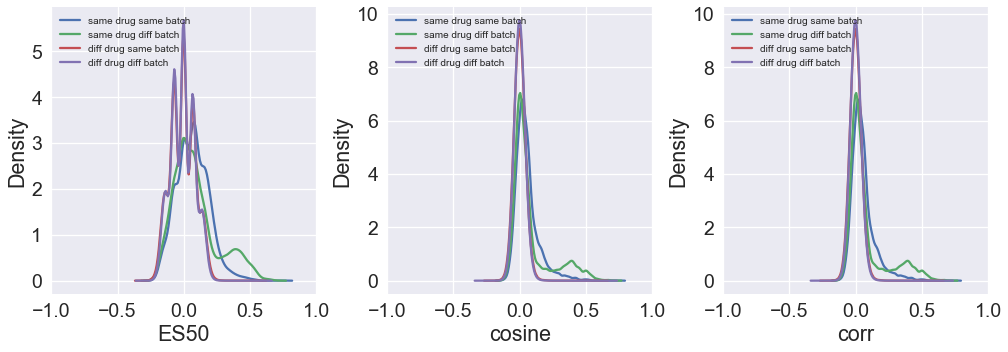

In [56]:
fig = density_plot_scores(res_scores8, meta_df_fwd)

84509
cosine 0.54253461062
corr 0.543375447897
ES50 0.540250859071


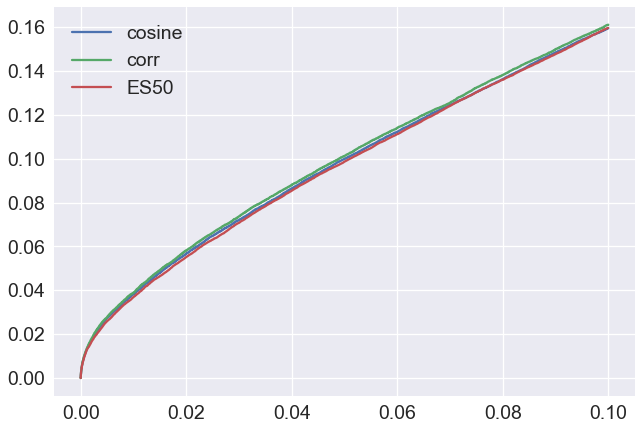

In [66]:
truths = get_ground_truth(res_scores1, meta_df, drug_moa_df)
print truths.sum()
fig, ax = plt.subplots()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores1, metric, truths)
    print metric, auroc
    
    ax.plot(fpr[fpr<0.1], tpr[fpr<0.1], label=metric)

ax.legend(loc='best')

106408
cosine 0.742771100788
corr 0.744559666131
ES50 0.732563752384


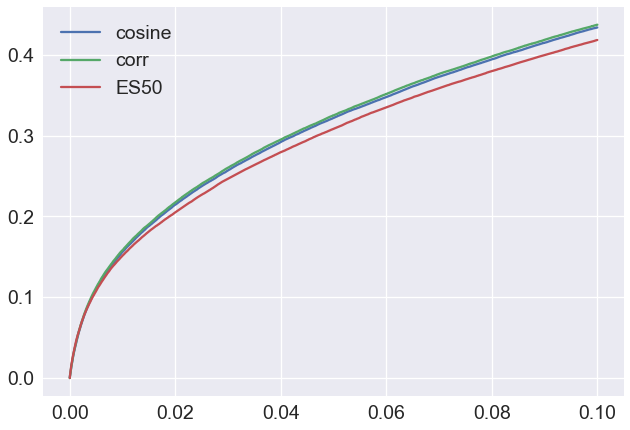

In [42]:
# Significant only
truths = get_ground_truth(res_scores1, meta_df, drug_moa_df)
print truths.sum()
fig, ax = plt.subplots()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores1, metric, truths)
    print metric, auroc
    
    ax.plot(fpr[fpr<0.1], tpr[fpr<0.1], label=metric)

ax.legend(loc='best')

102188
cosine 0.748283875616
corr 0.748283875616
ES50 0.731483794233


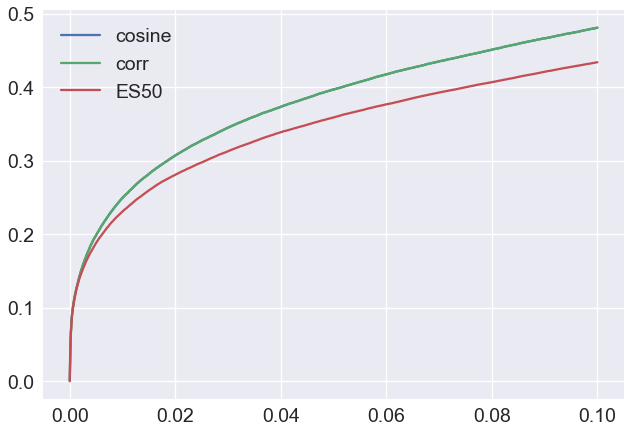

In [43]:
# Significant only
truths = get_ground_truth(res_scores3, meta_df_fwd, drug_moa_df)
print truths.sum()
fig, ax = plt.subplots()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores3, metric, truths)
    print metric, auroc
    
    ax.plot(fpr[fpr<0.1], tpr[fpr<0.1], label=metric)

ax.legend(loc='best')

In [53]:
truths = get_ground_truth(res_scores2, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores2, metric, truths)
    print metric, auroc

83204
cosine 0.564678481779
corr 0.564678481776
ES50 0.55730920453


83204
cosine 0.567929532288
corr 0.567929532288
ES50 0.559621825721


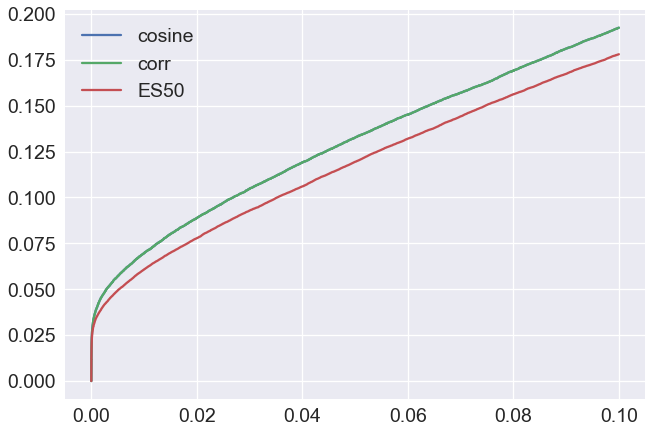

In [67]:
truths = get_ground_truth(res_scores3, meta_df_fwd, drug_moa_df)
print truths.sum()
fig, ax = plt.subplots()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores3, metric, truths)
    print metric, auroc
    ax.plot(fpr[fpr<0.1], tpr[fpr<0.1], label=metric)

ax.legend(loc='best')

In [55]:
truths = get_ground_truth(res_scores4, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores4, metric, truths)
    print metric, auroc

83204
cosine 0.552419491766
corr 0.553531741395
ES50 0.550279363065


In [52]:
truths = get_ground_truth(res_scores5, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores5, metric, truths)
    print metric, auroc

84147
cosine 0.556737366348
corr 0.556737366348
ES50 0.54910645409


In [53]:
truths = get_ground_truth(res_scores6, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores6, metric, truths)
    print metric, auroc

84147
cosine 0.550496046794
corr 0.551067564037
ES50 0.547757675872


In [57]:
truths = get_ground_truth(res_scores7, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores7, metric, truths)
    print metric, auroc

84147
cosine 0.559839223383
corr 0.559839223383
ES50 0.551242028809


In [58]:
truths = get_ground_truth(res_scores8, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores8, metric, truths)
    print metric, auroc

84147
cosine 0.559857111022
corr 0.559857111016
ES50 0.552101041741


## 2. Limiting signature pairs from the same cell lines

In [44]:
def limit_scores_df_to_same_cells(scores_df):
    cells_i = scores_df['sig_i'].map(lambda x: x.split(':')[0].split('_')[1])
    cells_j = scores_df['sig_j'].map(lambda x: x.split(':')[0].split('_')[1])
    
    mask = np.where(cells_i == cells_j)[0]
    
    return scores_df.iloc[mask]



In [57]:
res_scores1_same_cell = limit_scores_df_to_same_cells(res_scores1)
print res_scores1_same_cell.shape
res_scores1_same_cell.head()

(827986, 5)


,ES50,corr,cosine,sig_i,sig_j
67,0.217866,0.195277,0.188671,CPC006_SW948_6H:BRD-K09635314:80.0,CPC006_SW948_6H:BRD-K61250553:10.0
81,0.231918,0.167694,0.163014,CPC006_SW948_6H:BRD-K09635314:80.0,CPC006_SW948_6H:BRD-A18763547:10.0
281,0.320916,0.316421,0.332863,CPC006_SW948_6H:BRD-K09635314:80.0,CPC006_SW948_6H:BRD-K95609758:10.0
286,0.212554,0.212226,0.216280,CPC006_SW948_6H:BRD-K09635314:80.0,CPC006_SW948_6H:BRD-K62810658:10.0
1342,0.056864,0.084149,0.086201,CPC006_SW948_6H:BRD-K09635314:80.0,CPC006_SW948_6H:BRD-A62182663:10.0


In [58]:
truths = get_ground_truth(res_scores1_same_cell, meta_df, drug_moa_df)
print truths.sum(), truths.shape

for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores1_same_cell, metric, truths)
    print metric, auroc

6362 (827986,)
cosine 0.536350488767
corr 0.536744727094
ES50 0.536851625339


In [46]:
# Significant-only
res_scores1_same_cell = limit_scores_df_to_same_cells(res_scores1)
truths = get_ground_truth(res_scores1_same_cell, meta_df, drug_moa_df)
print truths.sum(), truths.shape
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores1_same_cell, metric, truths)
    print metric, auroc

7518 (904154,)
cosine 0.772824845844
corr 0.773880685721
ES50 0.765640386407


In [48]:
# Significant-only
res_scores3_same_cell = limit_scores_df_to_same_cells(res_scores3)
truths = get_ground_truth(res_scores3_same_cell, meta_df_fwd, drug_moa_df)
print truths.sum(), truths.shape
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores3_same_cell, metric, truths)
    print metric, auroc

6765 (875911,)
cosine 0.746332524974
corr 0.746332524974
ES50 0.740302383611


In [62]:
res_scores2_same_cell = limit_scores_df_to_same_cells(res_scores2)
truths = get_ground_truth(res_scores2_same_cell, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores2_same_cell, metric, truths)
    print metric, auroc

6131
cosine 0.57313458669
corr 0.57313458669
ES50 0.570243975741


In [63]:
res_scores3_same_cell = limit_scores_df_to_same_cells(res_scores3)
truths = get_ground_truth(res_scores3_same_cell, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores3_same_cell, metric, truths)
    print metric, auroc

6131
cosine 0.575526285191
corr 0.575526285191
ES50 0.567440094394


In [64]:
res_scores4_same_cell = limit_scores_df_to_same_cells(res_scores4)
truths = get_ground_truth(res_scores4_same_cell, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores4_same_cell, metric, truths)
    print metric, auroc

6131
cosine 0.555916867633
corr 0.557422779474
ES50 0.553139117924


In [61]:
res_scores5_same_cell = limit_scores_df_to_same_cells(res_scores5)
truths = get_ground_truth(res_scores5_same_cell, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores5_same_cell, metric, truths)
    print metric, auroc

6118
cosine 0.564271880479
corr 0.564271880479
ES50 0.560998718267


In [62]:
res_scores6_same_cell = limit_scores_df_to_same_cells(res_scores6)
truths = get_ground_truth(res_scores6_same_cell, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores6_same_cell, metric, truths)
    print metric, auroc

6118
cosine 0.558293294878
corr 0.559499300619
ES50 0.553403130622


In [63]:
res_scores7_same_cell = limit_scores_df_to_same_cells(res_scores7)
truths = get_ground_truth(res_scores7_same_cell, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores7_same_cell, metric, truths)
    print metric, auroc

6118
cosine 0.56699307726
corr 0.56699307726
ES50 0.560483841665


In [64]:
res_scores8_same_cell = limit_scores_df_to_same_cells(res_scores8)
truths = get_ground_truth(res_scores8_same_cell, meta_df_fwd, drug_moa_df)
print truths.sum()
for metric in ['cosine', 'corr', 'ES50']:
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores8_same_cell, metric, truths)
    print metric, auroc

6118
cosine 0.565678064209
corr 0.565678064209
ES50 0.558534023685


## Make ROC plots

84509
cosine 0.54253461062
ES50 0.540250859071
83204
cosine 0.567929532288
ES50 0.559621825721


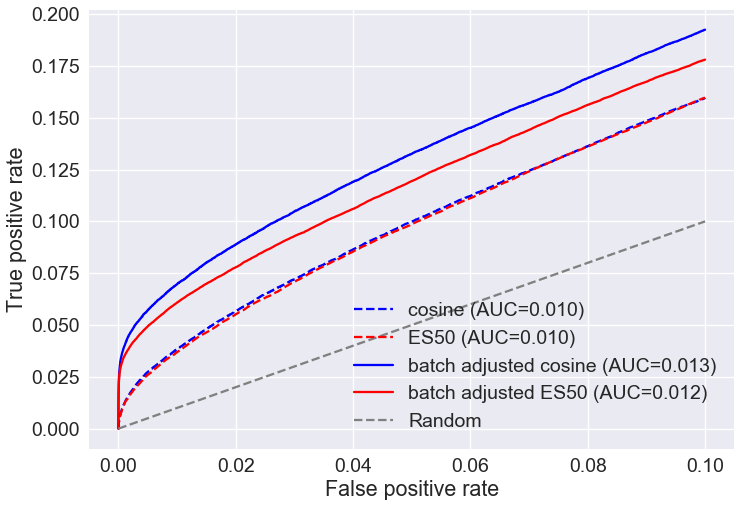

In [71]:
fig, ax = plt.subplots()
colors = ['b', 'r']
connectivity_metrics = ['cosine', 'ES50']

truths = get_ground_truth(res_scores1, meta_df, drug_moa_df)
print truths.sum()

for metric, color in zip(connectivity_metrics, colors):
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores1, metric, truths)
    print metric, auroc
    mask = fpr<0.1
    partial_auc = metrics.auc(fpr[mask], tpr[mask])
    ax.plot(fpr[mask], tpr[mask], ls='--', 
            label='%s (AUC=%.3f)'%(metric, partial_auc),
            color=color
           )

truths = get_ground_truth(res_scores3, meta_df_fwd, drug_moa_df)
print truths.sum()

for metric, color in zip(connectivity_metrics, colors):
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores3, metric, truths)
    print metric, auroc
    mask = fpr<0.1
    partial_auc = metrics.auc(fpr[mask], tpr[mask])
    ax.plot(fpr[mask], tpr[mask], 
            label='batch adjusted %s (AUC=%.3f)'%(metric, partial_auc),
            color=color
           )

ax.plot([0,0.1], [0,0.1], label='Random', ls='--', color='grey')
ax.legend(loc='best')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
fig.tight_layout()
fig.savefig('figs/partial_ROCs_signature_connections_MoA.pdf')

cosine 0.536350488767
ES50 0.536851625339
cosine 0.575526285191
ES50 0.567440094394


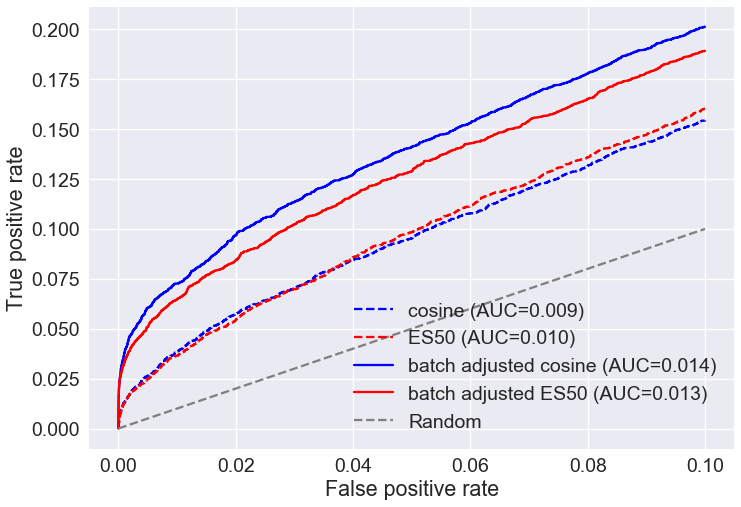

In [72]:
fig, ax = plt.subplots()

res_scores1_same_cell = limit_scores_df_to_same_cells(res_scores1)
truths = get_ground_truth(res_scores1_same_cell, meta_df, drug_moa_df)

for metric, color in zip(connectivity_metrics, colors):
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores1_same_cell, metric, truths)
    print metric, auroc
    mask = fpr<0.1
    partial_auc = metrics.auc(fpr[mask], tpr[mask])
    ax.plot(fpr[mask], tpr[mask], ls='--', 
            label='%s (AUC=%.3f)'%(metric, partial_auc),
            color=color
           )

res_scores3_same_cell = limit_scores_df_to_same_cells(res_scores3)
truths = get_ground_truth(res_scores3_same_cell, meta_df_fwd, drug_moa_df)

for metric, color in zip(connectivity_metrics, colors):
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores3_same_cell, metric, truths)
    print metric, auroc
    mask = fpr<0.1
    partial_auc = metrics.auc(fpr[mask], tpr[mask])
    ax.plot(fpr[mask], tpr[mask], 
            label='batch adjusted %s (AUC=%.3f)'%(metric, partial_auc),
            color=color
           )

ax.plot([0,0.1], [0,0.1], label='Random', ls='--', color='grey')
ax.legend(loc='best')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
fig.tight_layout()
fig.savefig('figs/partial_ROCs_signature_connections-same-cell_MoA.pdf')

106408
cosine 0.742771100788
ES50 0.732563752384
102188
cosine 0.748283875616
ES50 0.731483794233


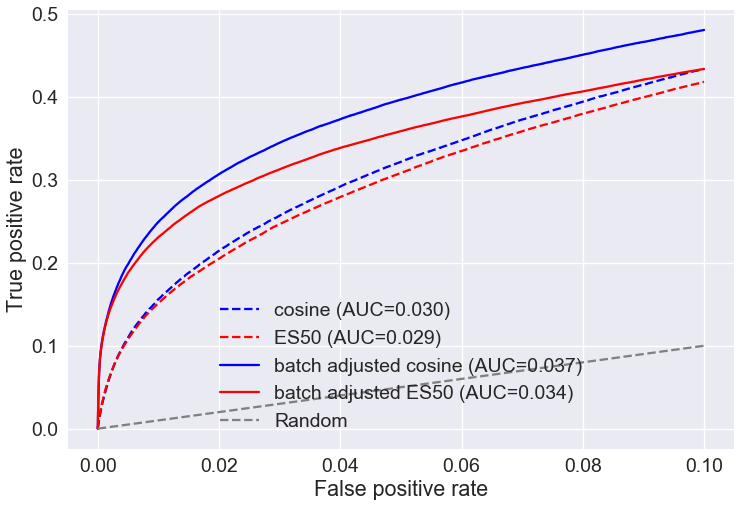

In [49]:
fig, ax = plt.subplots()
colors = ['b', 'r']
connectivity_metrics = ['cosine', 'ES50']

truths = get_ground_truth(res_scores1, meta_df, drug_moa_df)
print truths.sum()

for metric, color in zip(connectivity_metrics, colors):
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores1, metric, truths)
    print metric, auroc
    mask = fpr<0.1
    partial_auc = metrics.auc(fpr[mask], tpr[mask])
    ax.plot(fpr[mask], tpr[mask], ls='--', 
            label='%s (AUC=%.3f)'%(metric, partial_auc),
            color=color
           )

truths = get_ground_truth(res_scores3, meta_df_fwd, drug_moa_df)
print truths.sum()

for metric, color in zip(connectivity_metrics, colors):
    auroc, fpr, tpr, thresholds = get_roc_curve(res_scores3, metric, truths)
    print metric, auroc
    mask = fpr<0.1
    partial_auc = metrics.auc(fpr[mask], tpr[mask])
    ax.plot(fpr[mask], tpr[mask], 
            label='batch adjusted %s (AUC=%.3f)'%(metric, partial_auc),
            color=color
           )

ax.plot([0,0.1], [0,0.1], label='Random', ls='--', color='grey')
ax.legend(loc='best')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
fig.tight_layout()
fig.savefig('figs/partial_ROCs_signature_connections_MoA_significant_only.pdf')